In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, multiprocessing as mp, copy
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from ecology_functions import *

In [2]:
def propose_MALA(theta, grad, tau, update) :
    npr.seed()
    scipy.random.seed()
    return [theta[i] + update[i]*(tau[i]*grad[i] + np.sqrt(2*np.abs(tau[i]))*npr.randn(*np.shape(theta[i]))) for i in range(5)]

In [3]:
def adapt_tau(theta_mu, theta_m2) :
    return [0.4*(theta_m2[i]-theta_mu[i]**2) for i in range(5)]

In [4]:
def update_moments(theta_mu, theta_m2, theta, n) :
    theta_mu = [(n*theta_mu[i] + theta[i])/(n+1) for i in range(5)]
    theta_m2 = [(n*theta_m2[i] + theta[i]**2)/(n+1) for i in range(5)]
    return theta_mu, theta_m2

* Problem here, don't want to divide by 0 when tau[i] is 0.

In [5]:
def transition_prob_MALA(theta_curr, theta_prop, ll_curr, ll_prop, grad_curr, grad_prop, tau, power, update) :
    
    log_prior_curr, log_prior_prop = log_prior(theta_curr), log_prior(theta_prop) 
    a = power*(ll_prop-ll_curr) + (log_prior_prop-log_prior_curr)
    J, K = np.shape(theta_curr[1])
    
    # need to fix the problem of dividing by 0 when tau[i] and update[i] are 0
    b1, b2 = 0, 0
    for i in range(5) :
        if update[i] > 0 :
            b1 += -np.linalg.norm((theta_curr[i] - theta_prop[i] - tau[i]*grad_curr[i])/(2*np.sqrt(np.abs(tau[i]))))**2
            b2 += -np.linalg.norm((theta_prop[i] - theta_curr[i] - tau[i]*grad_prop[i])/(2*np.sqrt(np.abs(tau[i]))))**2
    return a + b1 - b2

In [6]:
def pMCMC_MALA(Y, x_0, n_particles, theta_0, n_mcmc, tau, update, adapt, start_adapt=0.2, power=1) :
    
    np.random.seed()
    scipy.random.seed()
    
    alpha_chain, lmbda_chain, c_chain, phi_chain, logsigmasq_chain, lls, theta_mu, theta_m2 = initialise(theta_0, n_mcmc)
    theta_chain = [alpha_chain, lmbda_chain, c_chain, phi_chain, logsigmasq_chain]
    
    theta_curr = [alpha_chain[0], lmbda_chain[0], c_chain[0], phi_chain[0], logsigmasq_chain[0]]    
    ll_curr, grad_curr = block_PF(Y, x_0, n_particles, theta_curr, calc_grad=True)
    accepted = 0
    last_jump = 0
    
    start = time()
    for n in range(n_mcmc) :
        theta_prop = propose_MALA(theta_curr, grad_curr, tau, update)
        ll_prop, grad_prop = block_PF(Y, x_0, n_particles, theta_prop, calc_grad=True)
        log_accept_prob = transition_prob_MALA(theta_curr, theta_prop, ll_curr, ll_prop, grad_curr, grad_prop, 
                                               tau, power, update)
        if np.log(npr.rand()) < log_accept_prob :
            ll_curr = np.copy(ll_prop)
            theta_curr = np.copy(theta_prop)
            grad_curr = np.copy(grad_prop)
            accepted += 1
            last_jump = n
        else :
            if n - last_jump > 50 :
                ll_curr, grad_curr = block_PF(Y, x_0, n_particles, theta_curr, calc_grad=True)
        if adapt :
            theta_mu, theta_m2 = update_moments(theta_mu, theta_m2, theta_curr, n+1)
            if n >= int(n_mcmc*start_adapt) : 
                tau = adapt_tau(theta_mu, theta_m2)
        
        if (10*(n+1))%n_mcmc == 0 :
            print(100*(n+1)/n_mcmc, "% over in", round((time()-start)/60,2),
                  "minutes; acceptance ratio =", 100*accepted/(n+1), "%")
           
        theta_chain = push(theta_chain, theta_curr, n+1)

    return theta_chain, theta_mu, theta_m2

#### Simulate observations:

In [7]:
T = 100
I = 5    # number of locations
J = 3    # number of species
K = 2    # number of latent factors

In [8]:
lmbda = npr.randn(J,K)
alpha = npr.randn(J)
c = 0
phi = 0.5
logsigmasq = 0
x_0 = npr.randn(I,K)

theta = [alpha, lmbda, c, phi, logsigmasq]
Y, X = simulate_data(x_0, T, J, theta)

In [9]:
update = [1, *np.zeros(4)]
eps = 5e-3
tau = [eps*np.ones(J), eps*np.ones((J,K)), eps, eps, eps]

In [10]:
n_particles = 1000
n_mcmc = 2000
theta_, theta_mu, theta_m2 = pMCMC_MALA(Y, x_0, n_particles, theta, n_mcmc, tau, update, adapt=True, start_adapt=0.5)

/home/postdoc/dsen/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


10.0 % over in 1.26 minutes; acceptance ratio = 21.0 %
20.0 % over in 2.5 minutes; acceptance ratio = 19.5 %
30.0 % over in 3.73 minutes; acceptance ratio = 18.0 %
40.0 % over in 4.96 minutes; acceptance ratio = 20.25 %
50.0 % over in 6.2 minutes; acceptance ratio = 19.6 %
60.0 % over in 7.45 minutes; acceptance ratio = 19.25 %
70.0 % over in 8.7 minutes; acceptance ratio = 18.5 %
80.0 % over in 9.95 minutes; acceptance ratio = 18.875 %
90.0 % over in 11.24 minutes; acceptance ratio = 18.0 %
100.0 % over in 12.5 minutes; acceptance ratio = 18.05 %


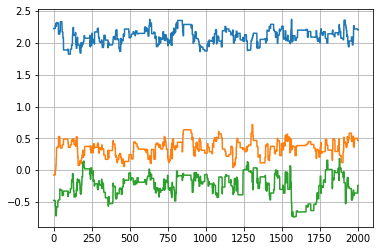

In [11]:
plt.plot(theta_[0])
plt.grid(True)